In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ijson
import re
from collections import defaultdict
import matplotlib.cm as cm

In [7]:
# data = pd.read_json('ratebeer.json')
# !pip install ijson

0. Сбор/выгрузка данных

In [8]:
def fix_json_file(input_file, output_file):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    fixed_lines = []
    json_obj = ''

    for line in lines:
        line = line.strip()
        if line:
            json_obj += line
        else:
            fixed_lines.append(json_obj)
            json_obj = ''

    # Write the fixed JSON objects to the output file
    with open(output_file, 'w') as f:
        for line in fixed_lines:
            f.write(line + '\n')

json_file = 'ratebeer.json'
fixed_file ='ratebeer_fixed.json'

In [12]:
fix_json_file(json_file, fixed_file)

In [14]:
def count_lines(filename):
    with open(filename, 'r') as f:
        lines = 0
        for line in f:
            lines += 1
    return lines

total_lines = count_lines(json_file)
total_lines

In [15]:
lines_to_load = int(total_lines * 0.1)
chunksize = int(lines_to_load / 10) + 1 #планирую загрузку в 10 чанков для 10% данных
lines_to_load, chunksize

In [56]:
chunks_loaded = 0
data_frames = []

In [96]:
json_file = 'ratebeer_fixed.json'
prefix = '' 

In [102]:
def load_chunk(chunk_size):
    records = []

    with open(json_file, 'r') as f:
        for i, line in enumerate(f):
            line = line.replace("'", '"')  # Replace single quotes with double quotes
            try:
                obj = json.loads(line)
                records.append(obj)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON object on line {i + 1}: {e}")

            if len(records) >= chunk_size:
                break

    return records

data_frames = []

# while True:
#     chunk_data = load_chunk(chunk_size)
#     if not chunk_data:
#         break
#     data_frames.append(pd.DataFrame(chunk_data))

# result_df = pd.concat(data_frames, ignore_index=True)

Json вообще не парсится - много проблем с обходом некорретного форматирования, решила решить проблему радикально: 

In [19]:
import random

with open('ratebeer.txt', 'r') as f:
    total_lines = f.read()

total_lines = total_lines.split('\n')
lines_to_load = int(len(total_lines) * 0.1)

In [21]:
selected_lines = random.sample(total_lines, lines_to_load) # выгружаем только 10% данных
df = pd.DataFrame([eval(line) for line in selected_lines])

In [22]:
#дата без пропусков
len(df.dropna(subset = 'review/profileName')), len(df)

(292416, 292416)

In [23]:
df.columns = df.columns.str.replace('/', '_')

In [24]:
df.columns

Index(['beer_name', 'beer_beerId', 'beer_brewerId', 'beer_ABV', 'beer_style',
       'review_appearance', 'review_aroma', 'review_palate', 'review_taste',
       'review_overall', 'review_time', 'review_profileName', 'review_text'],
      dtype='object')

1. EDA 

In [25]:
df.describe()

,beer_name,beer_beerId,beer_brewerId,beer_ABV,beer_style,review_appearance,review_aroma,review_palate,review_taste,review_overall,review_time,review_profileName,review_text
count,292416,292416,292416,292416,292416,292416,292416,292416,292416,292416,292416,292416,292416
unique,50501,50521,5829,488,89,5,10,5,10,20,4149,13009,291056
top,Pabst Blue Ribbon,734,32,5,India Pale Ale &#40;IPA&#41;,3/5,7/10,3/5,7/10,14/20,1188604800,Ungstrup,
freq,373,373,4732,25247,18505,127246,87000,138132,88600,43372,542,1557,516


In [26]:
df.head(3)

,beer_name,beer_beerId,beer_brewerId,beer_ABV,beer_style,review_appearance,review_aroma,review_palate,review_taste,review_overall,review_time,review_profileName,review_text
0,Brewsters Claudia,5477,998,4.5,Wheat Ale,2/5,7/10,3/5,5/10,8/20,1060387200,BeerLimey,"(Cask GBBF): Dense cloudy amber appearance, cl..."
1,Lagunitas Cruising with Ruben and The Jets,96186,1167,8.6,Imperial Stout,3/5,7/10,4/5,8/10,16/20,1241222400,NJBeerman013,"22 oz bottle. Pours a muddy, dark brown in co..."
2,Dogfish Head Raison D Extra,12834,198,18.5,American Strong Ale,4/5,8/10,4/5,8/10,15/20,1139702400,Dorwart,"UPDATED: MAR 22, 2010 (2005) release. Thin li..."


In [27]:
df['review_overall'] = df['review_overall'] .apply(lambda x: x.split('/')[0]).astype(int)

In [28]:
# df['review_profileName'].value_counts()[:10]
#есть прям ценители пива

In [29]:
top_reviewers = df.groupby('review_profileName')['review_overall'].agg(['count', 'mean']).sort_values(by='count', ascending=False)

print(top_reviewers.head(10))

                    count       mean
review_profileName                  
Ungstrup             1557  11.567759
fonefan              1548  12.125969
Papsoe               1445  11.855363
yespr                1338  12.355755
oh6gdx                974  11.737166
kp                    968  11.754132
omhper                940  11.160638
argo0                 841  12.583829
joergen               836  12.385167
Oakes                 832  11.778846


In [30]:
df.groupby('review_profileName').size().mean()
#то есть в average user оставляем 22 отзыва, остальные - энтузиасты 

22.477976785302484

In [31]:
len(df.groupby('review_profileName').size()[df.groupby('review_profileName').size() > 22])

2302

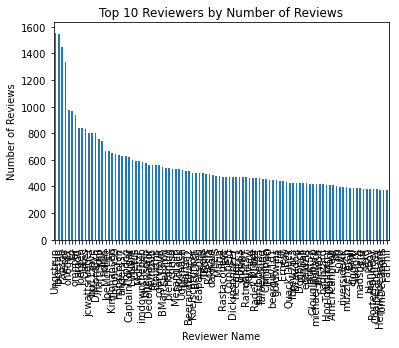

In [32]:
top_reviewers['count'].head(100).plot(kind='bar')
plt.title('Top 10 Reviewers by Number of Reviews')
plt.xlabel('Reviewer Name')
plt.ylabel('Number of Reviews')
plt.show()

Резонно оставить юзером, которые оставили "адекватное" кол-во отзывов на товары - отсечем по среднему + 5% 

In [33]:
df['review_profileName'].value_counts()[df['review_profileName'].value_counts() < 100]

Niko100         99
jstraw          99
kassner         99
GranvilleTim    99
padrefan98      99
                ..
LadyLilith       1
dantheman99      1
WhitePony813     1
aequity          1
Jaybeatle        1
Name: review_profileName, Length: 12248, dtype: int64

In [34]:
less_common_users = df['review_profileName'].value_counts() < 100
less_common_users = less_common_users[less_common_users].index
df = df[df['review_profileName'].isin(less_common_users)]

In [35]:
df['beer_name'].value_counts()[:10]

Pabst Blue Ribbon                                  290
Guinness Draught                                   277
Sierra Nevada Pale Ale &#40;Bottle&#41;            263
Budweiser                                          253
North Coast Old Rasputin Russian Imperial Stout    246
Dogfish Head 90 Minute Imperial IPA                243
Newcastle Brown Ale                                234
Chimay Bleue &#40;Blue&#41; / Grande Rserve        234
Corona Extra                                       233
Heineken                                           225
Name: beer_name, dtype: int64

In [36]:
# df.groupby(['beer_name']).review_overall.sum()

In [37]:
top_rated_beers = df.groupby('beer_name')['review_overall'].mean().sort_values(ascending=False)
print(top_rated_beers.head(10))

beer_name
Diekirch Grand Cru Ambree                  20.0
Rosengarten Maisgold Spezial Bier          20.0
Zero Gravity DKinna Bock                   20.0
Stadtguet Beginner                         20.0
Franziskaner Hefe-Weissbier Alkoholfrei    20.0
Bastone Witface                            20.0
Samuel Adams Bitter                        20.0
John Shippeys Bootlegger Nut Brown Ale     20.0
Fredericksburg Hoppy Holidaze              20.0
Rhinelander Light                          20.0
Name: review_overall, dtype: float64


In [38]:
counts = df.groupby('review_overall')['beer_name'].value_counts()
top_counts = counts.groupby(level=0).head(5)


top_counts = top_counts.unstack()
top_counts = top_counts.fillna(0)
top_counts = top_counts.sort_index(axis=1)

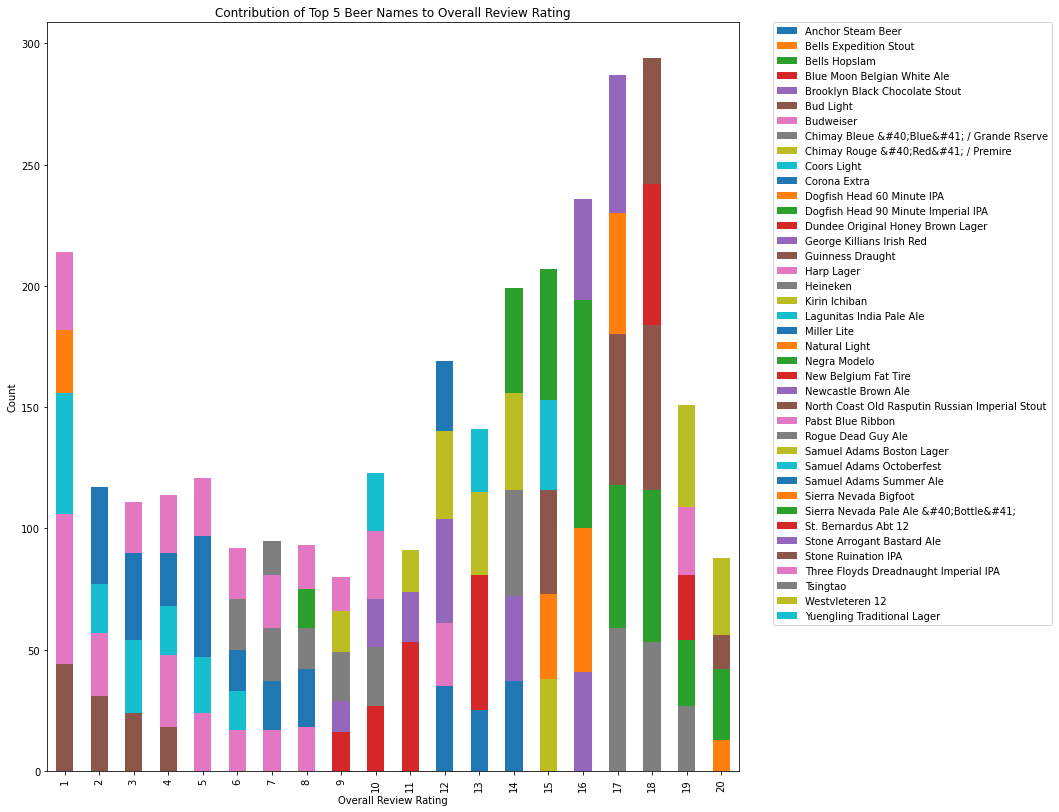

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
top_counts.plot(kind='bar', stacked=True, ax=ax)

plt.title('Contribution of Top 5 Beer Names to Overall Review Rating')
plt.xlabel('Overall Review Rating')
plt.ylabel('Count')

plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=1.5, wspace=0.4, hspace=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

График сложновато читать из-за обилия переменных, так как не все прокрашиваются в уникальными цветами. Но визуально нельзя сказать, что есть какой-то тренд по вкладу определного вида продукта в тот или иную оценку. 

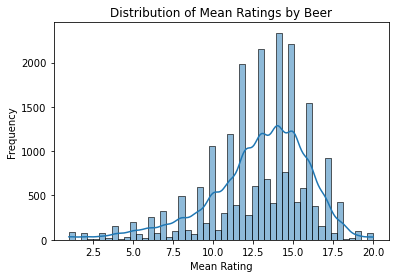

In [40]:
# df.groupby('beer_name')['review_overall'].mean().hist(bins = 50)

mean_ratings = df.groupby('beer_name')['review_overall'].mean()
sns.histplot(data=mean_ratings, bins=50, kde=True)
plt.title('Distribution of Mean Ratings by Beer')
plt.xlabel('Mean Rating')
plt.ylabel('Frequency')

plt.show()

2. Transition Matrix 

In [41]:
print(df.shape)
df.columns

(117042, 13)


Index(['beer_name', 'beer_beerId', 'beer_brewerId', 'beer_ABV', 'beer_style',
       'review_appearance', 'review_aroma', 'review_palate', 'review_taste',
       'review_overall', 'review_time', 'review_profileName', 'review_text'],
      dtype='object')

In [42]:
data = df[['beer_name', 'beer_beerId',
           'review_profileName','review_overall']].rename({'beer_name': 'item_name', 
                                                           'beer_beerId': 'item_id', 
                                                          'review_profileName': 'user_name', 
                                                          'review_overall' : 'rating'}, axis = 1)

In [46]:
import networkx as nx

In [47]:
G = nx.Graph()

In [311]:
# G.add_nodes_from(data_for_plot['item_id'].unique())
# for user, item_group in data_for_plot.groupby('user_name'):
#     item_group = item_group['item_id']
#     for item1, item2 in zip(item_group, item_group.shift(-1).dropna()):
#         if not G.has_edge(item1, item2):
#             G.add_edge(item1, item2, weight=1)
#         else:
#             G[item1][item2]['weight'] += 1

In [312]:
# pos = nx.spring_layout(G)

# edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
# nx.draw_networkx_nodes(G, pos, node_size=10, node_color='lightblue')
# nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.4)
# nx.draw_networkx_labels(G, pos, font_size=6, font_family='sans-serif')

# plt.axis('off')
# plt.show()

Поскольку мы работаем с данными юзер-продукт, то логично рассматривать информацию в виде двудольного графа. Попробуем для небольшого семпла: 

In [320]:
# data_for_plot = data.sample(10)

In [48]:
user_nodes = data['user_name'].unique()
item_nodes = data['item_id'].unique()
G.add_nodes_from(user_nodes, bipartite=0)
G.add_nodes_from(item_nodes, bipartite=1)
for user, item, rating in zip(data['user_name'], data['item_id'], data['rating']):
    G.add_edge(user, item, weight=rating)

# pos = nx.spring_layout(G)

# edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
# nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_size=2, node_color='lightblue')
# nx.draw_networkx_nodes(G, pos, nodelist=item_nodes, node_size=2, node_color='lightcoral')
# nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.4)
# nx.draw_networkx_labels(G, pos, font_size=6, font_family='sans-serif')

# plt.axis('off')
# plt.show()

nx.write_gexf(G, 'graph.gexf')

In [49]:
G_copy = G.copy()
train_edges = random.sample(list(G_copy.edges()), int(len(G_copy.edges())*0.8))

G_test = G_copy.copy()
G_test.remove_edges_from(train_edges)

# Calculating PageRank on the training set
train_df = pd.DataFrame(train_edges, columns=['user_name', 'item_id'])
train_df['rating'] = [G[u][v]['weight'] for u, v in train_edges]

# Calculating PageRank on the testing set
test_df = pd.DataFrame(G_test.edges(), columns=['user_name', 'item_id'])
test_df['rating'] = [G_test[u][v]['weight'] for u, v in G_test.edges()]

In [50]:
train_df.shape

(93400, 3)

In [51]:
test_df.shape

(23351, 3)

In [52]:
data.to_csv('beer_ratings_preproc_data.csv', index = False)

In [53]:
train_df.to_csv('beer_ratings_train.csv', index = False)

In [54]:
train_df.to_csv('beer_ratings_test.csv', index = False)